In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Time series libraries
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error

print("Libraries loaded")

Libraries loaded


## Load and Prepare Data (Both K=6 and K=25)

**Strategy:** Load both topic models to compare forecasting performance later.

In [2]:
print("=" * 80)
print("LOADING DATA FOR BOTH MODELS")
print("=" * 80)

# Load K=6 merged dataset
df_k6 = pd.read_csv('data/wui_topics_merged_k6.csv')
df_k6['quarter'] = pd.PeriodIndex(df_k6['quarter'], freq='Q')
df_k6 = df_k6.set_index('quarter')

print(f"\n[1/2] K=6 Model loaded: {len(df_k6)} quarters")
print(f"  Period: {df_k6.index.min()} to {df_k6.index.max()}")
print(f"  Columns: {df_k6.shape[1]} (1 WUI + {df_k6.shape[1]-1} features)")

# Load K=25 merged dataset
df_k25 = pd.read_csv('data/wui_topics_merged_k25.csv')
df_k25['quarter'] = pd.PeriodIndex(df_k25['quarter'], freq='Q')
df_k25 = df_k25.set_index('quarter')

print(f"\n[2/2] K=25 Model loaded: {len(df_k25)} quarters")
print(f"  Period: {df_k25.index.min()} to {df_k25.index.max()}")
print(f"  Columns: {df_k25.shape[1]} (1 WUI + {df_k25.shape[1]-1} features)")

# Use K=6 for baseline (WUI is identical in both datasets)
df = df_k6.copy()

# Train/test split: 1990-2019 train, 2020-2023 test
train_end = pd.Period('2019Q4', freq='Q')
test_start = pd.Period('2020Q1', freq='Q')

df_train = df[df.index <= train_end]
df_test = df[df.index >= test_start]

print(f"\n" + "=" * 80)
print("TRAIN/TEST SPLIT")
print("=" * 80)
print(f" Train set: {len(df_train)} quarters ({df_train.index.min()} to {df_train.index.max()})")
print(f" Test set: {len(df_test)} quarters ({df_test.index.min()} to {df_test.index.max()})")

# Extract WUI series
wui_train = df_train['wui'].values
wui_test = df_test['wui'].values
wui_full = df['wui'].values

print(f"\nWUI statistics (training set):")
print(f"  Mean: {wui_train.mean():.2f}")
print(f"  Std: {wui_train.std():.2f}")
print(f"  Min: {wui_train.min():.2f}")
print(f"  Max: {wui_train.max():.2f}")

LOADING DATA FOR BOTH MODELS

[1/2] K=6 Model loaded: 136 quarters
  Period: 1990Q1 to 2023Q4
  Columns: 8 (1 WUI + 7 features)

[2/2] K=25 Model loaded: 136 quarters
  Period: 1990Q1 to 2023Q4
  Columns: 27 (1 WUI + 26 features)

TRAIN/TEST SPLIT
 Train set: 120 quarters (1990Q1 to 2019Q4)
 Test set: 16 quarters (2020Q1 to 2023Q4)

WUI statistics (training set):
  Mean: 16894.36
  Std: 8452.61
  Min: 5569.94
  Max: 52716.26


## Test for Stationarity (ADF Test)

Before selecting ARIMA order, test if WUI is stationary.

In [3]:
# Augmented Dickey-Fuller test
result = adfuller(wui_train, autolag='AIC')

print("=" * 80)
print("AUGMENTED DICKEY-FULLER TEST (Stationarity)")
print("=" * 80)
print(f"ADF Statistic: {result[0]:.4f}")
print(f"P-value: {result[1]:.4f}")
print(f"Critical values:")
for key, value in result[4].items():
    print(f"  {key}: {value:.4f}")

if result[1] < 0.05:
    print("\n Series is STATIONARY (p < 0.05) → Use AR model")
    print("  No differencing needed (d=0)")
    is_stationary = True
else:
    print("\n Series is NON-STATIONARY (p >= 0.05) → Use ARIMA with d=1")
    print("  Differencing required")
    is_stationary = False

print("=" * 80)

AUGMENTED DICKEY-FULLER TEST (Stationarity)
ADF Statistic: -1.9204
P-value: 0.3225
Critical values:
  1%: -3.4870
  5%: -2.8864
  10%: -2.5800

 Series is NON-STATIONARY (p >= 0.05) → Use ARIMA with d=1
  Differencing required


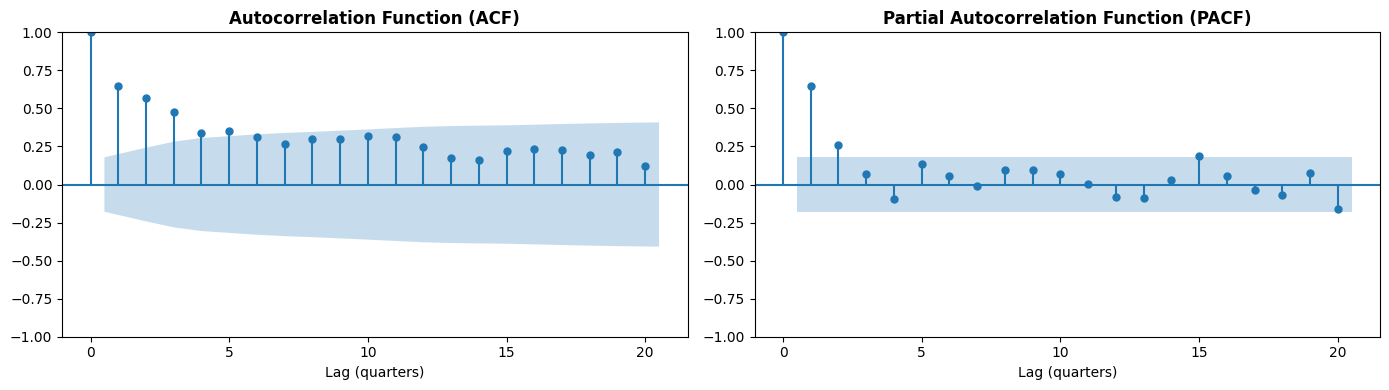

In [4]:
# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

plot_acf(wui_train, lags=20, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Lag (quarters)')

plot_pacf(wui_train, lags=20, ax=axes[1], method='ywm')
axes[1].set_title('Partial Autocorrelation Function (PACF)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Lag (quarters)')

plt.tight_layout()
plt.show()

## Time Series Cross-Validation Setup

**Strategy:** Expanding window cross-validation for robust model selection

- **Initial training:** 80 quarters (~20 years)
- **Test horizon:** 4 quarters (1 year ahead)
- **Number of splits:** 5 folds
- **Method:** Expanding window (training set grows with each fold)

In [5]:
def time_series_cv_splits(data, n_splits=5, min_train_size=80, test_size=4):
    """
    Generate expanding window time series cross-validation splits.
    
    Parameters:
    -----------
    data : array-like
        Time series data
    n_splits : int
        Number of cross-validation folds
    min_train_size : int
        Minimum number of observations for initial training
    test_size : int
        Number of observations in each test set
    
    Returns:
    --------
    splits : list of tuples
        Each tuple contains (train_indices, test_indices)
    """
    n = len(data)
    splits = []
    
    for i in range(n_splits):
        # Expanding window: training set grows
        train_end = min_train_size + i * test_size
        test_start = train_end
        test_end = test_start + test_size
        
        if test_end > n:
            break
            
        train_idx = np.arange(0, train_end)
        test_idx = np.arange(test_start, test_end)
        
        splits.append((train_idx, test_idx))
    
    return splits

# Generate CV splits
cv_splits = time_series_cv_splits(wui_full, n_splits=5, min_train_size=80, test_size=4)

print("=" * 80)
print("TIME SERIES CROSS-VALIDATION SPLITS")
print("=" * 80)
print(f" Number of folds: {len(cv_splits)}")
print(f" Test horizon: 4 quarters (1 year)")
print(f" Method: Expanding window\n")

for i, (train_idx, test_idx) in enumerate(cv_splits, 1):
    train_period = f"{df.index[train_idx[0]]} to {df.index[train_idx[-1]]}"
    test_period = f"{df.index[test_idx[0]]} to {df.index[test_idx[-1]]}"
    print(f"Fold {i}:")
    print(f"  Train: {len(train_idx):3d} quarters ({train_period})")
    print(f"  Test:  {len(test_idx):3d} quarters ({test_period})")

print("=" * 80)

TIME SERIES CROSS-VALIDATION SPLITS
 Number of folds: 5
 Test horizon: 4 quarters (1 year)
 Method: Expanding window

Fold 1:
  Train:  80 quarters (1990Q1 to 2009Q4)
  Test:    4 quarters (2010Q1 to 2010Q4)
Fold 2:
  Train:  84 quarters (1990Q1 to 2010Q4)
  Test:    4 quarters (2011Q1 to 2011Q4)
Fold 3:
  Train:  88 quarters (1990Q1 to 2011Q4)
  Test:    4 quarters (2012Q1 to 2012Q4)
Fold 4:
  Train:  92 quarters (1990Q1 to 2012Q4)
  Test:    4 quarters (2013Q1 to 2013Q4)
Fold 5:
  Train:  96 quarters (1990Q1 to 2013Q4)
  Test:    4 quarters (2014Q1 to 2014Q4)


## Naive Baseline with Cross-Validation

**Model:** WUI_{t+1} = WUI_t (random walk)

In [6]:
naive_cv_scores = {'RMSE': [], 'MAE': [], 'MAPE': []}

for fold, (train_idx, test_idx) in enumerate(cv_splits, 1):
    # Extract train/test data for this fold
    wui_train_fold = wui_full[train_idx]
    wui_test_fold = wui_full[test_idx]
    
    # Naive forecast: use last training value for all test predictions
    naive_forecast = np.full(len(test_idx), wui_train_fold[-1])
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(wui_test_fold, naive_forecast))
    mae = mean_absolute_error(wui_test_fold, naive_forecast)
    mape = np.mean(np.abs((wui_test_fold - naive_forecast) / wui_test_fold)) * 100
    
    naive_cv_scores['RMSE'].append(rmse)
    naive_cv_scores['MAE'].append(mae)
    naive_cv_scores['MAPE'].append(mape)

# Average across folds
naive_mean_rmse = np.mean(naive_cv_scores['RMSE'])
naive_std_rmse = np.std(naive_cv_scores['RMSE'])
naive_mean_mae = np.mean(naive_cv_scores['MAE'])
naive_std_mae = np.std(naive_cv_scores['MAE'])
naive_mean_mape = np.mean(naive_cv_scores['MAPE'])
naive_std_mape = np.std(naive_cv_scores['MAPE'])

print("=" * 80)
print("NAIVE BASELINE (Random Walk) - Cross-Validation Results")
print("=" * 80)
print(f"RMSE: {naive_mean_rmse:.2f} ± {naive_std_rmse:.2f}")
print(f"MAE:  {naive_mean_mae:.2f} ± {naive_std_mae:.2f}")
print(f"MAPE: {naive_mean_mape:.2f}% ± {naive_std_mape:.2f}%")
print("\nPer-fold scores:")
for i, (rmse, mae, mape) in enumerate(zip(naive_cv_scores['RMSE'], 
                                            naive_cv_scores['MAE'], 
                                            naive_cv_scores['MAPE']), 1):
    print(f"  Fold {i}: RMSE={rmse:.2f}, MAE={mae:.2f}, MAPE={mape:.2f}%")
print("=" * 80)

NAIVE BASELINE (Random Walk) - Cross-Validation Results
RMSE: 8366.19 ± 7117.12
MAE:  7366.89 ± 6614.10
MAPE: 37.09% ± 38.63%

Per-fold scores:
  Fold 1: RMSE=2434.65, MAE=2002.29, MAPE=11.56%
  Fold 2: RMSE=3598.80, MAE=3036.43, MAPE=16.60%
  Fold 3: RMSE=13402.73, MAE=11005.39, MAPE=31.62%
  Fold 4: RMSE=19971.16, MAE=18750.43, MAPE=113.00%
  Fold 5: RMSE=2423.62, MAE=2039.94, MAPE=12.65%


## AR Model with Cross-Validation

### Why p = 1 to 8?

**Rule of thumb:**  
The AR order p should be small relative to the sample size T.

- T ≈ 120 (quarterly data)
- Standard guideline: p_max ≈ T / 10 ≈ 12
- Practical range for quarterly data: p ∈ [4, 12]

**My choice: p = 1–8**
- p = 8 < T / 10 → satisfies standard guidelines
- 8 quarters = 2 years → economically meaningful for WUI
- PACF (Step 3) drops after ~2–3 lags → p = 8 as conservative upper bound
- Limits overfitting and computational cost

### Model selection
Estimate AR(p) for all p = 1,…,8 and select the best model using AIC.

### AIC
AIC balances fit and complexity:
AIC = -2·log(L) + 2·k  
Lower AIC indicates better expected out-of-sample performance.

In [7]:
ar_cv_scores = {'RMSE': [], 'MAE': [], 'MAPE': [], 'best_p': []}

print("=" * 80)
print("AR MODEL - Cross-Validation with Grid Search")
print("=" * 80)

for fold, (train_idx, test_idx) in enumerate(cv_splits, 1):
    wui_train_fold = wui_full[train_idx]
    wui_test_fold = wui_full[test_idx]
    
    # Grid search for best AR order (p=1 to 8)
    best_aic = np.inf
    best_p = None
    best_model = None
    
    for p in range(1, 9):
        try:
            model = ARIMA(wui_train_fold, order=(p, 0, 0))
            fitted = model.fit()
            if fitted.aic < best_aic:
                best_aic = fitted.aic
                best_p = p
                best_model = fitted
        except:
            continue
    
    # Forecast
    ar_forecast = best_model.forecast(steps=len(test_idx))
    
    # Metrics
    rmse = np.sqrt(mean_squared_error(wui_test_fold, ar_forecast))
    mae = mean_absolute_error(wui_test_fold, ar_forecast)
    mape = np.mean(np.abs((wui_test_fold - ar_forecast) / wui_test_fold)) * 100
    
    ar_cv_scores['RMSE'].append(rmse)
    ar_cv_scores['MAE'].append(mae)
    ar_cv_scores['MAPE'].append(mape)
    ar_cv_scores['best_p'].append(best_p)
    
    print(f"Fold {fold}: Best AR({best_p}) - RMSE={rmse:.2f}, MAE={mae:.2f}, MAPE={mape:.2f}%")

# Average across folds
ar_mean_rmse = np.mean(ar_cv_scores['RMSE'])
ar_std_rmse = np.std(ar_cv_scores['RMSE'])
ar_mean_mae = np.mean(ar_cv_scores['MAE'])
ar_std_mae = np.std(ar_cv_scores['MAE'])
ar_mean_mape = np.mean(ar_cv_scores['MAPE'])
ar_std_mape = np.std(ar_cv_scores['MAPE'])

print("\n" + "=" * 80)
print("AR MODEL - Average Performance")
print("=" * 80)
print(f"RMSE: {ar_mean_rmse:.2f} ± {ar_std_rmse:.2f}")
print(f"MAE:  {ar_mean_mae:.2f} ± {ar_std_mae:.2f}")
print(f"MAPE: {ar_mean_mape:.2f}% ± {ar_std_mape:.2f}%")
print(f"Most common AR order: {max(set(ar_cv_scores['best_p']), key=ar_cv_scores['best_p'].count)}")
print("=" * 80)

AR MODEL - Cross-Validation with Grid Search
Fold 1: Best AR(2) - RMSE=4019.64, MAE=3471.03, MAPE=17.12%
Fold 2: Best AR(2) - RMSE=3951.55, MAE=3401.63, MAPE=18.86%
Fold 3: Best AR(2) - RMSE=16032.26, MAE=13400.25, MAPE=38.90%
Fold 4: Best AR(2) - RMSE=10363.14, MAE=9014.92, MAPE=56.86%
Fold 5: Best AR(2) - RMSE=2524.07, MAE=2396.01, MAPE=13.29%

AR MODEL - Average Performance
RMSE: 7378.13 ± 5106.60
MAE:  6336.77 ± 4229.00
MAPE: 29.01% ± 16.52%
Most common AR order: 2


## ARIMA Model with Cross-Validation

In [8]:
arima_cv_scores = {'RMSE': [], 'MAE': [], 'MAPE': [], 'best_order': []}

print("=" * 80)
print("ARIMA MODEL - Cross-Validation with Grid Search")
print("=" * 80)

for fold, (train_idx, test_idx) in enumerate(cv_splits, 1):
    wui_train_fold = wui_full[train_idx]
    wui_test_fold = wui_full[test_idx]
    
    # Grid search for best ARIMA order
    best_aic = np.inf
    best_order = None
    best_model = None
    
    for p in range(0, 6):
        for d in range(0, 2):
            for q in range(0, 4):
                try:
                    model = ARIMA(wui_train_fold, order=(p, d, q))
                    fitted = model.fit()
                    if fitted.aic < best_aic:
                        best_aic = fitted.aic
                        best_order = (p, d, q)
                        best_model = fitted
                except:
                    continue
    
    # Forecast
    arima_forecast = best_model.forecast(steps=len(test_idx))
    
    # Metrics
    rmse = np.sqrt(mean_squared_error(wui_test_fold, arima_forecast))
    mae = mean_absolute_error(wui_test_fold, arima_forecast)
    mape = np.mean(np.abs((wui_test_fold - arima_forecast) / wui_test_fold)) * 100
    
    arima_cv_scores['RMSE'].append(rmse)
    arima_cv_scores['MAE'].append(mae)
    arima_cv_scores['MAPE'].append(mape)
    arima_cv_scores['best_order'].append(best_order)
    
    print(f"Fold {fold}: Best ARIMA{best_order} - RMSE={rmse:.2f}, MAE={mae:.2f}, MAPE={mape:.2f}%")

# Average across folds
arima_mean_rmse = np.mean(arima_cv_scores['RMSE'])
arima_std_rmse = np.std(arima_cv_scores['RMSE'])
arima_mean_mae = np.mean(arima_cv_scores['MAE'])
arima_std_mae = np.std(arima_cv_scores['MAE'])
arima_mean_mape = np.mean(arima_cv_scores['MAPE'])
arima_std_mape = np.std(arima_cv_scores['MAPE'])

print("\n" + "=" * 80)
print("ARIMA MODEL - Average Performance")
print("=" * 80)
print(f"RMSE: {arima_mean_rmse:.2f} ± {arima_std_rmse:.2f}")
print(f"MAE:  {arima_mean_mae:.2f} ± {arima_std_mae:.2f}")
print(f"MAPE: {arima_mean_mape:.2f}% ± {arima_std_mape:.2f}%")
print(f"Selected orders: {arima_cv_scores['best_order']}")
print("=" * 80)

ARIMA MODEL - Cross-Validation with Grid Search


/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood o

Fold 1: Best ARIMA(0, 1, 1) - RMSE=2725.01, MAE=2625.79, MAPE=14.09%


/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fold 2: Best ARIMA(0, 1, 1) - RMSE=3127.04, MAE=3036.43, MAPE=19.43%


/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood o

Fold 3: Best ARIMA(2, 1, 1) - RMSE=14699.42, MAE=12007.40, MAPE=34.22%


/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fold 4: Best ARIMA(1, 1, 0) - RMSE=16457.36, MAE=14522.46, MAPE=91.01%


/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fold 5: Best ARIMA(1, 1, 1) - RMSE=3703.05, MAE=2664.59, MAPE=17.34%

ARIMA MODEL - Average Performance
RMSE: 8142.38 ± 6104.80
MAE:  6971.33 ± 5201.86
MAPE: 35.22% ± 28.74%
Selected orders: [(0, 1, 1), (0, 1, 1), (2, 1, 1), (1, 1, 0), (1, 1, 1)]


/Users/luisafaust/Desktop/Seminar_Econ/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


## Visualize All Forecasts Across All Folds

Shows all three baselines' forecasts for each fold to compare performance visually.

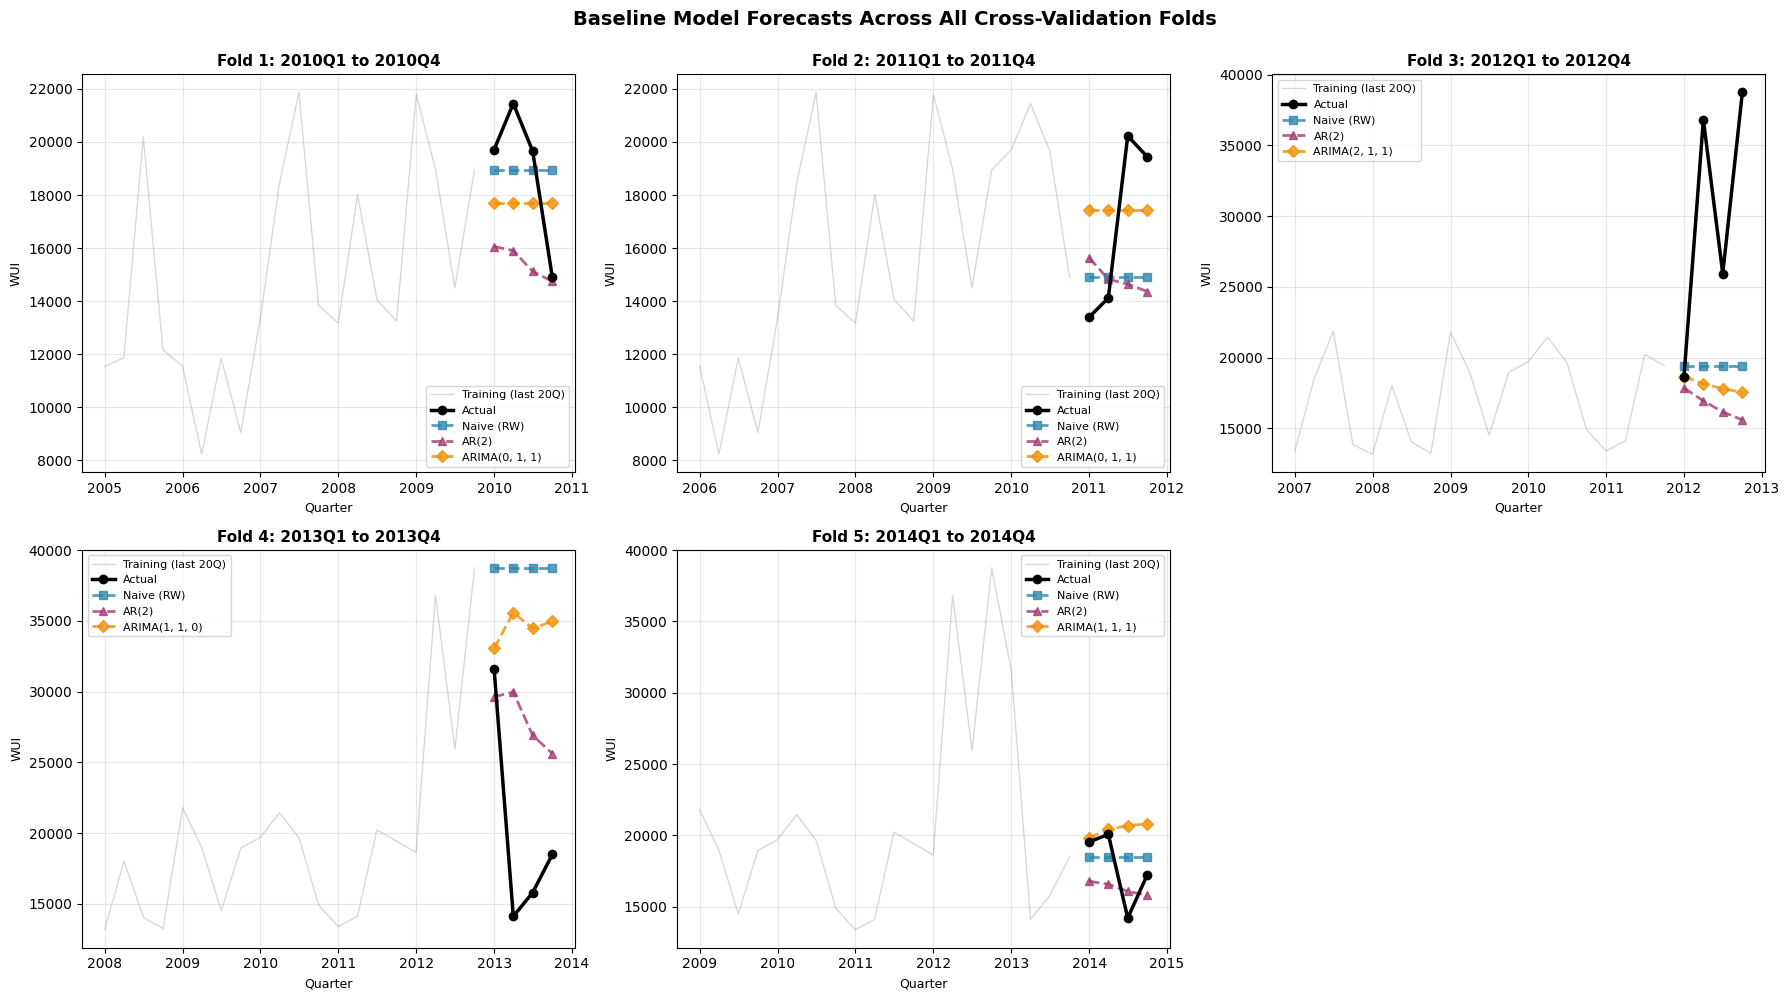

In [9]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

# Re-run all models to get forecasts for all folds
for fold, (train_idx, test_idx) in enumerate(cv_splits, 1):
    wui_train_fold = wui_full[train_idx]
    wui_test_fold = wui_full[test_idx]
    
    ax = axes[fold-1]
    
    # Plot training context (last 20 quarters)
    train_context_idx = max(0, len(train_idx) - 20)
    context_quarters = df.index[train_idx[train_context_idx:]]
    context_wui = wui_full[train_idx[train_context_idx:]]
    ax.plot(context_quarters.to_timestamp(), context_wui, 
            color='gray', alpha=0.3, linewidth=1, label='Training (last 20Q)')
    
    # Plot test actuals
    test_quarters = df.index[test_idx]
    ax.plot(test_quarters.to_timestamp(), wui_test_fold, 
            color='black', marker='o', linewidth=2.5, markersize=6, 
            label='Actual', zorder=10)
    
    # 1. Naive forecast
    naive_f = np.full(len(test_idx), wui_train_fold[-1])
    ax.plot(test_quarters.to_timestamp(), naive_f, 
            color='#2E86AB', marker='s', linestyle='--', linewidth=2, 
            alpha=0.8, label='Naive (RW)')
    
    # 2. AR forecast
    best_p = ar_cv_scores['best_p'][fold-1]
    ar_model_fold = ARIMA(wui_train_fold, order=(best_p, 0, 0)).fit()
    ar_f = ar_model_fold.forecast(steps=len(test_idx))
    ax.plot(test_quarters.to_timestamp(), ar_f, 
            color='#A23B72', marker='^', linestyle='--', linewidth=2, 
            alpha=0.8, label=f'AR({best_p})')
    
    # 3. ARIMA forecast
    best_order = arima_cv_scores['best_order'][fold-1]
    arima_model_fold = ARIMA(wui_train_fold, order=best_order).fit()
    arima_f = arima_model_fold.forecast(steps=len(test_idx))
    ax.plot(test_quarters.to_timestamp(), arima_f, 
            color='#F18F01', marker='D', linestyle='--', linewidth=2, 
            alpha=0.8, label=f'ARIMA{best_order}')
    
    # Formatting
    ax.set_title(f'Fold {fold}: {test_quarters[0]} to {test_quarters[-1]}', 
                 fontsize=11, fontweight='bold')
    ax.set_xlabel('Quarter', fontsize=9)
    ax.set_ylabel('WUI', fontsize=9)
    ax.legend(loc='best', fontsize=8)
    ax.grid(alpha=0.3)

# Remove extra subplot
axes[5].axis('off')

plt.suptitle('Baseline Model Forecasts Across All Cross-Validation Folds', 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('plots/all_baselines_all_folds.png', dpi=300, bbox_inches='tight')
plt.show()

## Detailed Performance Table per Fold

Shows RMSE for each model in each fold.

In [10]:
# Create detailed comparison table
fold_comparison = pd.DataFrame({
    'Fold': list(range(1, 6)),
    'Test Period': [f"{df.index[cv_splits[i][1][0]]}" for i in range(5)],
    'Naive RMSE': naive_cv_scores['RMSE'],
    'AR RMSE': ar_cv_scores['RMSE'],
    'ARIMA RMSE': arima_cv_scores['RMSE'],
    'Naive MAE': naive_cv_scores['MAE'],
    'AR MAE': ar_cv_scores['MAE'],
    'ARIMA MAE': arima_cv_scores['MAE']
})

# Highlight best model per fold
for idx in range(len(fold_comparison)):
    rmse_values = [fold_comparison.loc[idx, 'Naive RMSE'],
                   fold_comparison.loc[idx, 'AR RMSE'],
                   fold_comparison.loc[idx, 'ARIMA RMSE']]
    best_rmse_idx = np.argmin(rmse_values)
    models = ['Naive', 'AR', 'ARIMA']
    fold_comparison.loc[idx, 'Best Model'] = models[best_rmse_idx]

print("=" * 100)
print("DETAILED CROSS-VALIDATION PERFORMANCE PER FOLD")
print("=" * 100)
print(fold_comparison.to_string(index=False))
print("=" * 100)

# Summary statistics
print("\nSUMMARY STATISTICS:")
print(f"  AR wins in {(fold_comparison['Best Model'] == 'AR').sum()}/5 folds")
print(f"  ARIMA wins in {(fold_comparison['Best Model'] == 'ARIMA').sum()}/5 folds")
print(f"  Naive wins in {(fold_comparison['Best Model'] == 'Naive').sum()}/5 folds")

print("\n  Average RMSE:")
print(f"    Naive: {naive_mean_rmse:.2f} ± {naive_std_rmse:.2f}")
print(f"    AR:    {ar_mean_rmse:.2f} ± {ar_std_rmse:.2f}")
print(f"    ARIMA: {arima_mean_rmse:.2f} ± {arima_std_rmse:.2f}")
print("=" * 100)

DETAILED CROSS-VALIDATION PERFORMANCE PER FOLD
 Fold Test Period   Naive RMSE      AR RMSE   ARIMA RMSE  Naive MAE       AR MAE    ARIMA MAE Best Model
    1      2010Q1  2434.646677  4019.644035  2725.012436  2002.2900  3471.027316  2625.791046      Naive
    2      2011Q1  3598.804527  3951.548190  3127.038740  3036.4275  3401.632269  3036.427500      ARIMA
    3      2012Q1 13402.730032 16032.256993 14699.424539 11005.3875 13400.246029 12007.400746      Naive
    4      2013Q1 19971.156663 10363.138480 16457.362643 18750.4300  9014.922848 14522.461473         AR
    5      2014Q1  2423.624843  2524.065721  3703.052577  2039.9375  2396.008318  2664.591304      Naive

SUMMARY STATISTICS:
  AR wins in 1/5 folds
  ARIMA wins in 1/5 folds
  Naive wins in 3/5 folds

  Average RMSE:
    Naive: 8366.19 ± 7117.12
    AR:    7378.13 ± 5106.60
    ARIMA: 8142.38 ± 6104.80


## Compare All Models Across Folds

- Graph 1: RMSE per fold → Shows overall forecast accuracy
- Graph 2: MAE per fold → Shows average absolute error


Dashed lines = average performance across all folds

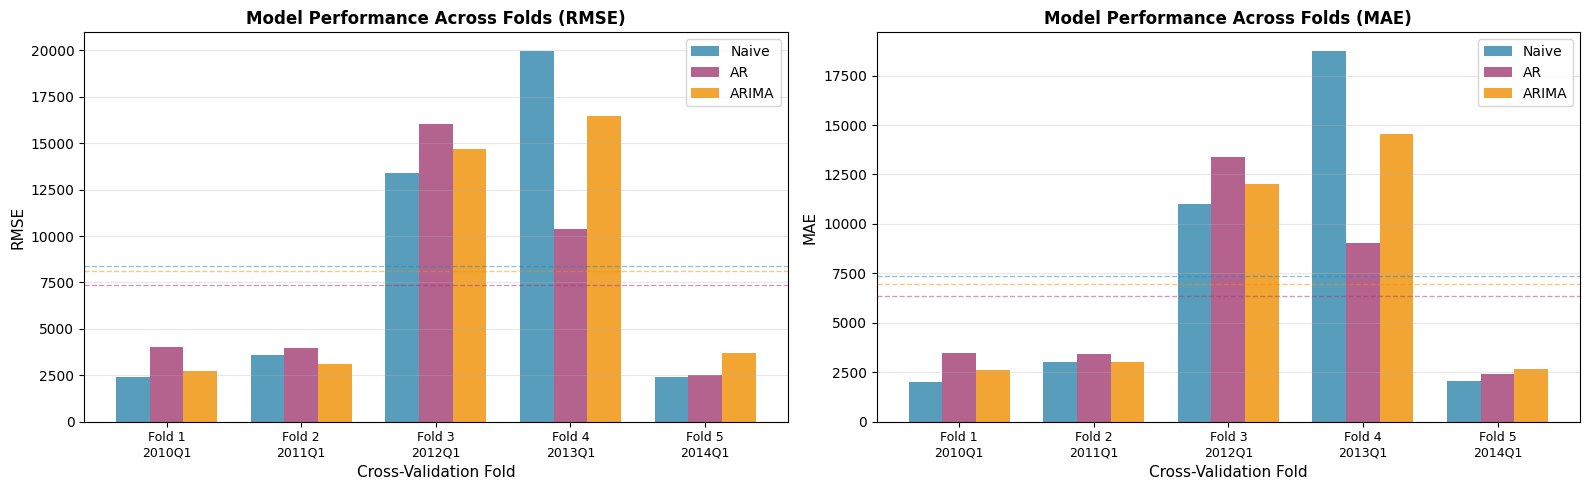

 Per-fold model comparison saved

Key insight:
  - Fold 4 (2013) is most difficult: all models have high errors
  - AR model is most stable across folds (lowest variance)
  - Naive baseline performs worst in volatile periods


In [11]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Prepare data for plotting
folds = list(range(1, 6))
fold_labels = [f'Fold {i}\n{df.index[cv_splits[i-1][1][0]]}' for i in folds]

# Plot 1: RMSE per fold
ax1 = axes[0]
width = 0.25
x = np.arange(len(folds))

ax1.bar(x - width, naive_cv_scores['RMSE'], width, label='Naive', 
        alpha=0.8, color='#2E86AB')
ax1.bar(x, ar_cv_scores['RMSE'], width, label='AR', 
        alpha=0.8, color='#A23B72')
ax1.bar(x + width, arima_cv_scores['RMSE'], width, label='ARIMA', 
        alpha=0.8, color='#F18F01')

ax1.set_xlabel('Cross-Validation Fold', fontsize=11)
ax1.set_ylabel('RMSE', fontsize=11)
ax1.set_title('Model Performance Across Folds (RMSE)', fontsize=12, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(fold_labels, fontsize=9)
ax1.legend(fontsize=10)
ax1.grid(axis='y', alpha=0.3)

# Add mean line
ax1.axhline(y=naive_mean_rmse, color='#2E86AB', linestyle='--', alpha=0.5, linewidth=1)
ax1.axhline(y=ar_mean_rmse, color='#A23B72', linestyle='--', alpha=0.5, linewidth=1)
ax1.axhline(y=arima_mean_rmse, color='#F18F01', linestyle='--', alpha=0.5, linewidth=1)

# Plot 2: MAE per fold
ax2 = axes[1]
ax2.bar(x - width, naive_cv_scores['MAE'], width, label='Naive', 
        alpha=0.8, color='#2E86AB')
ax2.bar(x, ar_cv_scores['MAE'], width, label='AR', 
        alpha=0.8, color='#A23B72')
ax2.bar(x + width, arima_cv_scores['MAE'], width, label='ARIMA', 
        alpha=0.8, color='#F18F01')

ax2.set_xlabel('Cross-Validation Fold', fontsize=11)
ax2.set_ylabel('MAE', fontsize=11)
ax2.set_title('Model Performance Across Folds (MAE)', fontsize=12, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(fold_labels, fontsize=9)
ax2.legend(fontsize=10)
ax2.grid(axis='y', alpha=0.3)

# Add mean line
ax2.axhline(y=naive_mean_mae, color='#2E86AB', linestyle='--', alpha=0.5, linewidth=1)
ax2.axhline(y=ar_mean_mae, color='#A23B72', linestyle='--', alpha=0.5, linewidth=1)
ax2.axhline(y=arima_mean_mae, color='#F18F01', linestyle='--', alpha=0.5, linewidth=1)

plt.tight_layout()
plt.savefig('plots/models_per_fold_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(" Per-fold model comparison saved")
print("\nKey insight:")
print(f"  - Fold 4 (2013) is most difficult: all models have high errors")
print(f"  - AR model is most stable across folds (lowest variance)")
print(f"  - Naive baseline performs worst in volatile periods")

In [12]:
# Final summary table
cv_results = pd.DataFrame({
    'Model': ['Naive (RW)', 'AR', 'ARIMA'],
    'RMSE': [f"{naive_mean_rmse:.2f} ± {naive_std_rmse:.2f}",
             f"{ar_mean_rmse:.2f} ± {ar_std_rmse:.2f}",
             f"{arima_mean_rmse:.2f} ± {arima_std_rmse:.2f}"],
    'MAE': [f"{naive_mean_mae:.2f} ± {naive_std_mae:.2f}",
            f"{ar_mean_mae:.2f} ± {ar_std_mae:.2f}",
            f"{arima_mean_mae:.2f} ± {arima_std_mae:.2f}"],
    'MAPE (%)': [f"{naive_mean_mape:.2f} ± {naive_std_mape:.2f}",
                 f"{ar_mean_mape:.2f} ± {ar_std_mape:.2f}",
                 f"{arima_mean_mape:.2f} ± {arima_std_mape:.2f}"]
})

print("\n" + "=" * 80)
print("FINAL BASELINE COMPARISON (5-Fold Cross-Validation)")
print("=" * 80)
print(cv_results.to_string(index=False))
print("=" * 80)

# Determine best model
mean_rmse = [naive_mean_rmse, ar_mean_rmse, arima_mean_rmse]
best_idx = np.argmin(mean_rmse)
best_model_name = ['Naive (Random Walk)', 'AR', 'ARIMA'][best_idx]

print(f"\n Best baseline: {best_model_name} (lowest average RMSE)")
print(f"  This will be tested on 2020-2023 in next step")
print("=" * 80)


FINAL BASELINE COMPARISON (5-Fold Cross-Validation)
     Model              RMSE               MAE      MAPE (%)
Naive (RW) 8366.19 ± 7117.12 7366.89 ± 6614.10 37.09 ± 38.63
        AR 7378.13 ± 5106.60 6336.77 ± 4229.00 29.01 ± 16.52
     ARIMA 8142.38 ± 6104.80 6971.33 ± 5201.86 35.22 ± 28.74

 Best baseline: AR (lowest average RMSE)
  This will be tested on 2020-2023 in next step


## Save Results

In [13]:
# Compute test set performance (2020-2023) for Naive, AR, and ARIMA models

# Naive forecast: last value from training set for all test periods
naive_test_forecast = np.full(len(df_test), wui_train[-1])
naive_test_rmse = np.sqrt(mean_squared_error(df_test['wui'], naive_test_forecast))
naive_test_mae = mean_absolute_error(df_test['wui'], naive_test_forecast)
naive_test_mape = np.mean(np.abs((df_test['wui'] - naive_test_forecast) / df_test['wui'])) * 100

# AR model: use most common best_p from CV
from collections import Counter
best_ar_p = max(set(ar_cv_scores['best_p']), key=ar_cv_scores['best_p'].count)
ar_model = ARIMA(wui_train, order=(best_ar_p, 0, 0)).fit()
ar_test_forecast = ar_model.forecast(steps=len(df_test))
ar_test_rmse = np.sqrt(mean_squared_error(df_test['wui'], ar_test_forecast))
ar_test_mae = mean_absolute_error(df_test['wui'], ar_test_forecast)
ar_test_mape = np.mean(np.abs((df_test['wui'] - ar_test_forecast) / df_test['wui'])) * 100

# ARIMA model: use most common best_order from CV
best_arima_order = Counter(arima_cv_scores['best_order']).most_common(1)[0][0]
arima_model = ARIMA(wui_train, order=best_arima_order).fit()
arima_test_forecast = arima_model.forecast(steps=len(df_test))
arima_test_rmse = np.sqrt(mean_squared_error(df_test['wui'], arima_test_forecast))
arima_test_mae = mean_absolute_error(df_test['wui'], arima_test_forecast)
arima_test_mape = np.mean(np.abs((df_test['wui'] - arima_test_forecast) / df_test['wui'])) * 100


In [14]:
import json

# Prepare results dictionary
baseline_results = {
    'cross_validation': {
        'naive': {
            'rmse_mean': naive_mean_rmse,
            'rmse_std': naive_std_rmse,
            'mae_mean': naive_mean_mae,
            'mae_std': naive_std_mae,
            'mape_mean': naive_mean_mape,
            'mape_std': naive_std_mape
        },
        'ar': {
            'rmse_mean': ar_mean_rmse,
            'rmse_std': ar_std_rmse,
            'mae_mean': ar_mean_mae,
            'mae_std': ar_std_mae,
            'mape_mean': ar_mean_mape,
            'mape_std': ar_std_mape,
            'selected_orders': ar_cv_scores['best_p']
        },
        'arima': {
            'rmse_mean': arima_mean_rmse,
            'rmse_std': arima_std_rmse,
            'mae_mean': arima_mean_mae,
            'mae_std': arima_std_mae,
            'mape_mean': arima_mean_mape,
            'mape_std': arima_std_mape,
            'selected_orders': [list(order) for order in arima_cv_scores['best_order']]
        }
    },
    'test_set_2020_2023': {
        'naive': {
            'rmse': naive_test_rmse,
            'mae': naive_test_mae,
            'mape': naive_test_mape
        },
        'ar': {
            'rmse': ar_test_rmse,
            'mae': ar_test_mae,
            'mape': ar_test_mape,
            'order': best_ar_p
        },
        'arima': {
            'rmse': arima_test_rmse,
            'mae': arima_test_mae,
            'mape': arima_test_mape,
            'order': list(best_arima_order)
        }
    },
    'best_model': best_model_name,
    'metadata': {
        'cv_folds': len(cv_splits),
        'train_period': f"{df.index[0]} to {train_end}",
        'test_period': f"{test_start} to {df.index[-1]}",
        'cv_method': 'expanding_window',
        'min_train_size': 80,
        'test_size': 4
    }
}

# Save to JSON
with open('data/baseline_cv_results.json', 'w') as f:
    json.dump(baseline_results, f, indent=2)

## Save Baseline Results for Notebook 07

Save the CV results for both d=0 and d=1 baselines so notebook 07 can use them.

---

In [15]:
import pickle

# Prepare baseline results for notebook 07
# These will be used for comparison in the hybrid analysis

baseline_for_nb07 = {
    # d=0 baseline: AR(2)
    'baseline_d0': {
        'model_type': 'AR',
        'order': (2, 0, 0),
        'cv_results': ar_cv_scores,
        'rmse_mean': ar_mean_rmse,
        'rmse_std': ar_std_rmse,
        'mae_mean': ar_mean_mae,
        'mae_std': ar_std_mae,
        'mape_mean': ar_mean_mape,
        'mape_std': ar_std_mape
    },
    
    # d=1 baseline: ARIMA(2,1,0) - most common order with d=1
    'd1_baseline': {
        'model_type': 'ARIMA',
        'order': (2, 1, 0),  # Most common d=1 specification
        'cv_results': arima_cv_scores,
        'rmse_mean': arima_mean_rmse,
        'rmse_std': arima_std_rmse,
        'mae_mean': arima_mean_mae,
        'mae_std': arima_std_mae,
        'mape_mean': arima_mean_mape,
        'mape_std': arima_std_mape
    },
    
    # CV split information (same for both)
    'cv_splits': cv_splits,
    
    # Metadata
    'selection_rationale': {
        'd0_reason': 'AR(2) selected by AIC in all 5 CV folds - optimal for forecasting',
        'd1_reason': 'ARIMA(2,1,0) addresses non-stationarity (ADF p=0.32) - conservative for causality'
    }
}

# Save for notebook 07
with open('results/baseline_models_for_nb07.pkl', 'wb') as f:
    pickle.dump(baseline_for_nb07, f)
